In [1]:
%matplotlib inline
import os
import time
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import lasagne
import theano
import theano.tensor as T
import pylab as P
from DiscreteLayer import DiscreteLayer
os.environ['THEANO_FLAGS']='device=gpu0'
np.random.seed(123)

Using gpu device 0: Tesla K40c (CNMeM is enabled with initial size: 69.0% of memory, cuDNN 5105)
/home/ilker/anaconda2/envs/theano/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:601: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
# Constants
conv = lasagne.layers.Conv2DLayer
pool = lasagne.layers.MaxPool2DLayer
NUM_EPOCHS = 50
BATCH_SIZE = 256
LEARNING_RATE = 0.001
DIM = 60
NUM_CLASSES = 10
mnist_cluttered = "mnist_cluttered_60x60_6distortions.npz"
#DISC
DISC = True
MINS = (.3, -.3, -.8, -.3, .5, -0.7)
MAXS = (1.1, .1, 1.1, .4, 1.1, 1.5)
RANGES = (50, 50, 50, 50, 50, 50)

In [3]:
def load_data():
    data = np.load(mnist_cluttered)
    X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
    X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
    X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)

    # reshape for convolutions
    X_train = X_train.reshape((X_train.shape[0], 1, DIM, DIM))
    X_valid = X_valid.reshape((X_valid.shape[0], 1, DIM, DIM))
    X_test = X_test.reshape((X_test.shape[0], 1, DIM, DIM))
    
    print "Train samples:", X_train.shape
    print "Validation samples:", X_valid.shape
    print "Test samples:", X_test.shape

    return dict(
        X_train=lasagne.utils.floatX(X_train),
        y_train=y_train.astype('int32'),
        X_valid=lasagne.utils.floatX(X_valid),
        y_valid=y_valid.astype('int32'),
        X_test=lasagne.utils.floatX(X_test),
        y_test=y_test.astype('int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_height=X_train.shape[2],
        input_width=X_train.shape[3],
        output_dim=10,)
data = load_data()

Train samples: (50000, 1, 60, 60)
Validation samples: (10000, 1, 60, 60)
Test samples: (10000, 1, 60, 60)


In [4]:
def build_model(input_width, input_height, output_dim, mins, maxs, ranges,
                batch_size=BATCH_SIZE, withdisc=True):
    ini = lasagne.init.HeUniform()
    l_in = lasagne.layers.InputLayer(shape=(None, 1, input_width, input_height),)

    # Localization network
    b = np.zeros((2, 3), dtype=theano.config.floatX)
    b[0, 0] = 1
    b[1, 1] = 1
    b = b.flatten()
    loc_l1 = pool(l_in, pool_size=(2, 2))
    loc_l2 = conv(
        loc_l1, num_filters=20, filter_size=(5, 5), W=ini)
    loc_l3 = pool(loc_l2, pool_size=(2, 2))
    loc_l4 = conv(loc_l3, num_filters=20, filter_size=(5, 5), W=ini)
    loc_l5 = lasagne.layers.DenseLayer(
        loc_l4, num_units=50, W=lasagne.init.HeUniform('relu'))
    loc_out = lasagne.layers.DenseLayer(
        loc_l5, num_units=6, b=b, W=lasagne.init.Constant(0.0), 
        nonlinearity=lasagne.nonlinearities.identity, name='param_regressor')
    
    if withdisc:
        l_dis = DiscreteLayer(loc_out, mins, maxs, ranges, name='disclayer')
        print("Using Discret. Layer")
    else:
        l_dis = loc_out
        Print("No Disc. Layer")
    
    # Transformer network
    l_trans1 = lasagne.layers.TransformerLayer(l_in, l_dis, downsample_factor=3.0)
    print "Transformer network output shape: ", l_trans1.output_shape
    
    # Classification network
    class_l1 = conv(
        l_trans1,
        num_filters=32,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    class_l2 = pool(class_l1, pool_size=(2, 2))
    class_l3 = conv(
        class_l2,
        num_filters=32,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    class_l4 = pool(class_l3, pool_size=(2, 2))
    class_l5 = lasagne.layers.DenseLayer(
        class_l4,
        num_units=256,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )

    l_out = lasagne.layers.DenseLayer(
        class_l5,
        num_units=output_dim,
        nonlinearity=lasagne.nonlinearities.softmax,
        W=ini,
    )

    return l_out, l_trans1

model, l_transform = build_model(DIM, DIM, NUM_CLASSES, MINS, MAXS, RANGES, withdisc=DISC)
model_params = lasagne.layers.get_all_params(model, trainable=True)

Using Discret. Layer
Transformer network output shape:  (None, 1, 20, 20)


In [5]:
X = T.tensor4(dtype=theano.config.floatX)
y = T.ivector()

## Layer History
l_disc = next(l for l in lasagne.layers.get_all_layers(model) if l.name is 'disclayer')
l_paramreg = next(l for l in lasagne.layers.get_all_layers(model) if l.name is 'param_regressor')

l_disc_output, l_paramreg_output = lasagne.layers.get_output([l_disc, l_paramreg], X, deterministic=False)
## Layer History

# training output
output_train = lasagne.layers.get_output(model, X, deterministic=False)

# evaluation output. Also includes output of transform for plotting
output_eval, transform_eval = lasagne.layers.get_output([model, l_transform], X, deterministic=True)

sh_lr = theano.shared(lasagne.utils.floatX(LEARNING_RATE))
cost = T.mean(T.nnet.categorical_crossentropy(output_train, y))
updates = lasagne.updates.adam(cost, model_params, learning_rate=sh_lr)

train = theano.function([X, y], [cost, output_train, l_disc_output, l_paramreg_output], updates=updates)
eval = theano.function([X], [output_eval, transform_eval])

In [6]:
def train_epoch(X, y):
    # History Keeping
    param_output = []
    disc_output = []
    # History
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    correct = 0
    for i in range(num_batches):
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch = X[idx]
        y_batch = y[idx]
        cost_batch, output_train, l_disc_output, l_paramreg_output = train(X_batch, y_batch)
        param_output = np.append(param_output, l_paramreg_output)
        disc_output = np.append(disc_output, l_disc_output)
        costs += [cost_batch]
        preds = np.argmax(output_train, axis=-1)
        correct += np.sum(y_batch == preds)
        
    return np.mean(costs), correct / float(num_samples), param_output, disc_output


def eval_epoch(X, y):
    output_eval, transform_eval = eval(X)
    preds = np.argmax(output_eval, axis=-1)
    acc = np.mean(preds == y)
    return acc, transform_eval

# Training

In [7]:
theano.config.exception_verbosity = 'high'
valid_accs, train_accs, test_accs = [], [], []
param_outputs, disc_outputs = [], []
total_time = 0
try:
    for n in range(NUM_EPOCHS):
        start_time = time.time()
        train_cost, train_acc, param_output, disc_output = train_epoch(data['X_train'], data['y_train'])
        valid_acc, valid_trainsform = eval_epoch(data['X_valid'], data['y_valid'])
        test_acc, test_transform = eval_epoch(data['X_test'], data['y_test'])
        valid_accs += [valid_acc]
        test_accs += [test_acc]
        train_accs += [train_acc]
        #import pdb; pdb.set_trace()
        param_outputs = np.append(param_outputs, param_output)
        disc_outputs = np.append(disc_outputs, disc_output)
        
        if (n+1) % 20 == 0:
            new_lr = sh_lr.get_value() * 0.7
            print "New LR:", new_lr
            sh_lr.set_value(lasagne.utils.floatX(new_lr))
        time_spent = time.time() - start_time
        total_time += time_spent
        print "Epoch {0}: Train cost {1}, Train acc {2}, val acc {3}, test acc {4}, took {5:.3} sec.".format(
                n, train_cost, train_acc, valid_acc, test_acc, time_spent)
except KeyboardInterrupt:
    print "\nTotal time spent: {0:.5} seconds\nTraing Acc: {1}\nTest Acc: {2}\nValidation Acc: {3}".format(total_time,
                                                                                                         train_acc,
                                                                                                         test_acc,
                                                                                                         valid_acc)
    pass

Epoch 0: Train cost 1.8165024519, Train acc 0.35544, val acc 0.6284, test acc 0.6175, took 6.02 sec.
Epoch 1: Train cost 0.912810325623, Train acc 0.7008, val acc 0.7601, test acc 0.761, took 5.99 sec.
Epoch 2: Train cost 0.630319535732, Train acc 0.7965, val acc 0.8095, test acc 0.8107, took 5.98 sec.
Epoch 3: Train cost 0.51012301445, Train acc 0.83576, val acc 0.8516, test acc 0.8542, took 5.98 sec.
Epoch 4: Train cost 0.44694301486, Train acc 0.85688, val acc 0.8675, test acc 0.8652, took 5.98 sec.
Epoch 5: Train cost 0.368229687214, Train acc 0.88154, val acc 0.8769, test acc 0.8755, took 5.97 sec.
Epoch 6: Train cost 0.337495058775, Train acc 0.8916, val acc 0.897, test acc 0.8949, took 5.98 sec.
Epoch 7: Train cost 0.303595334291, Train acc 0.9005, val acc 0.8997, test acc 0.8962, took 6.0 sec.
Epoch 8: Train cost 0.265000194311, Train acc 0.91454, val acc 0.9161, test acc 0.9128, took 6.0 sec.
Epoch 9: Train cost 0.257479012012, Train acc 0.9173, val acc 0.9204, test acc 0.9192

# Plot Results

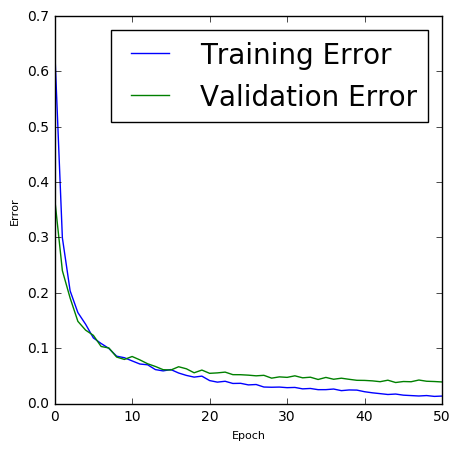

In [8]:
plt.figure(figsize=(5,5))
plt.plot(1-np.array(train_accs), label='Training Error')
plt.plot(1-np.array(valid_accs), label='Validation Error')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=8)
plt.ylabel('Error', fontsize=8)
plt.show()

# Histograms

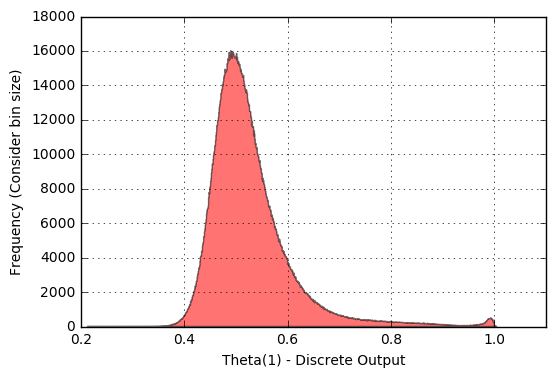

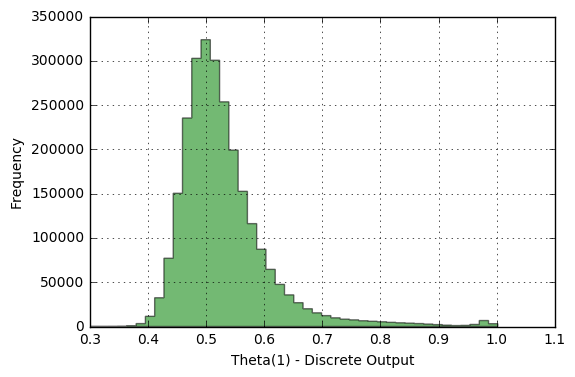

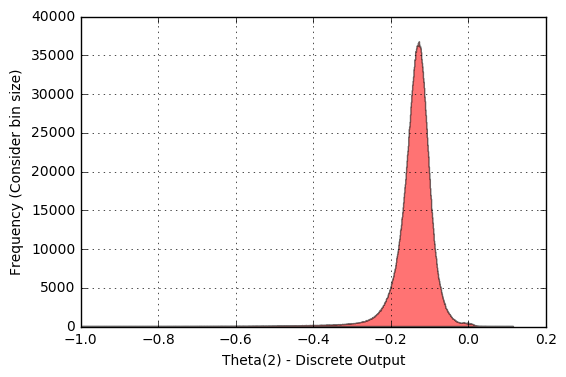

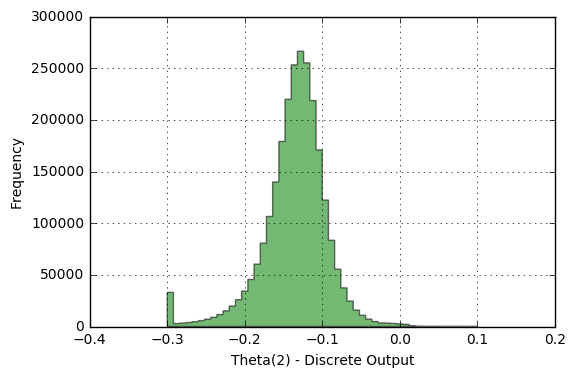

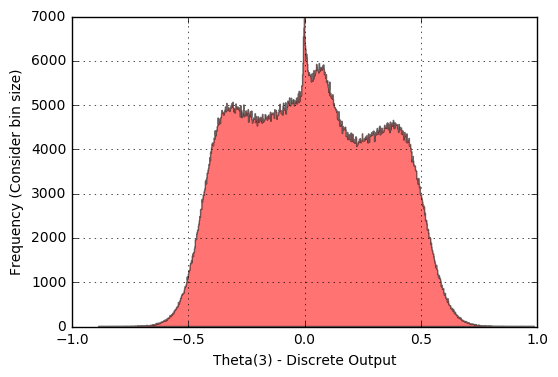

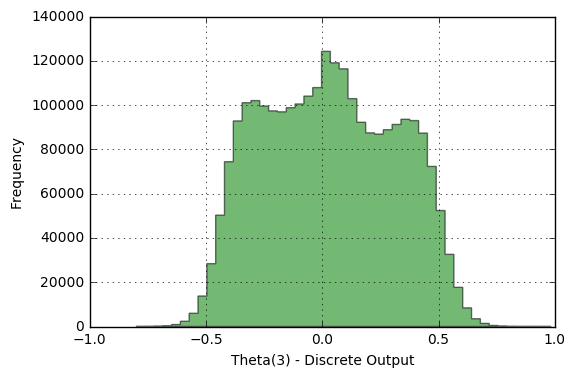

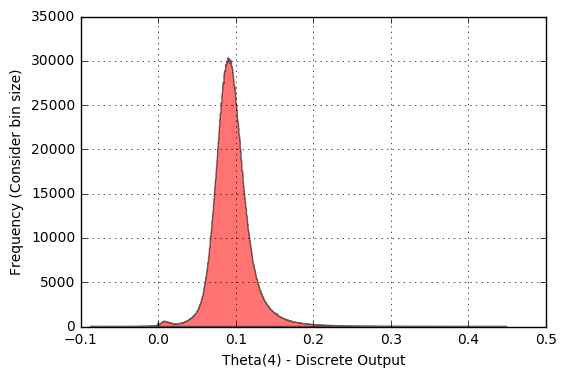

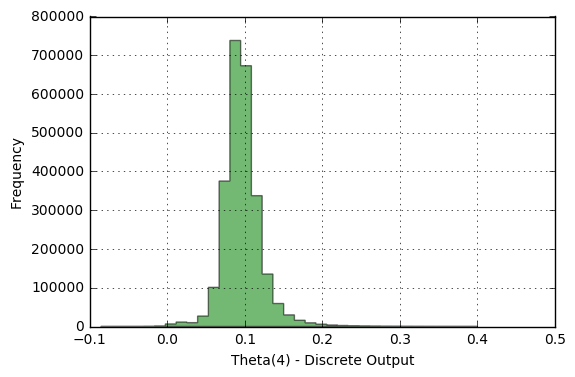

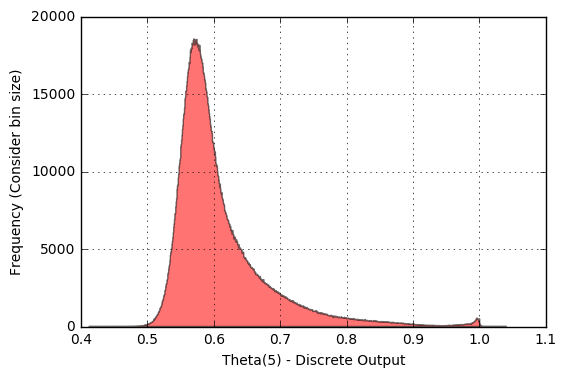

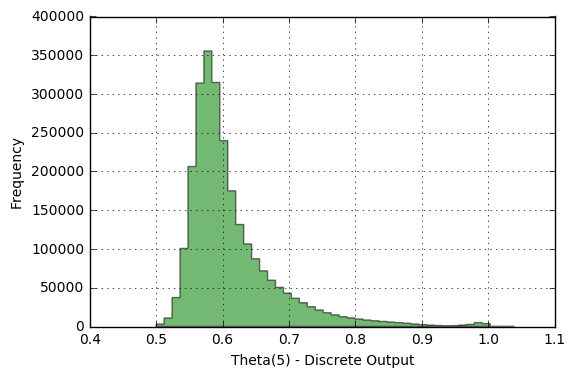

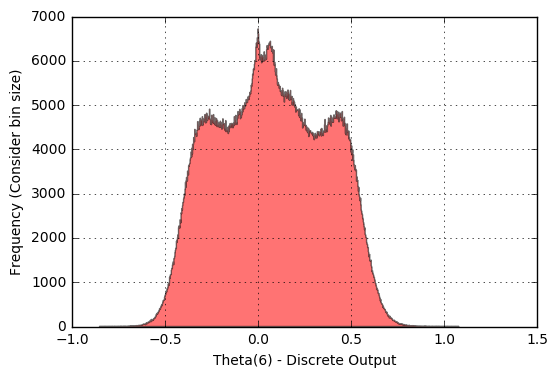

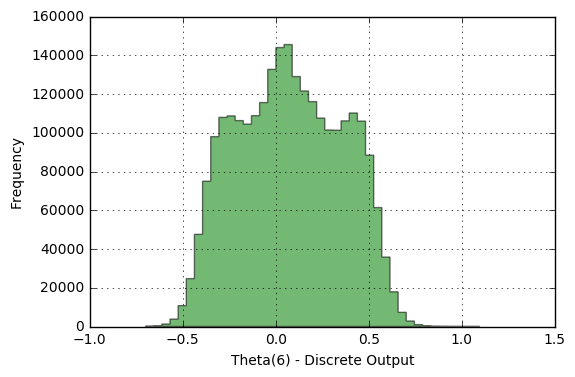

In [9]:
# Histograms
dense_params = param_outputs.reshape((-1, 6))
disc_params = disc_outputs.reshape((-1, 6))
bin_count = 1000
plot_over = False

for i in range(0, 6):
    dns = dense_params[:, i]
    dsc = disc_params[:, i]
    
    #PS: Using normed histograms to plot them over
    # Theta x Dense
    plt.figure()
    n, bins, patches = plt.hist(dns, bin_count, normed=plot_over, histtype='stepfilled')
    plt.setp(patches, 'facecolor', 'r', 'alpha', 0.55)
    if not plot_over:
        plt.xlabel(('Theta({0}) - Discrete Output').format(i+1))
        plt.ylabel('Frequency (Consider bin size)')
        plt.grid(True)
        plt.figure()
    
    # Theta x Discrete
    n, bins, patches = plt.hist(dsc, len(np.unique(dsc)), normed=plot_over, histtype='stepfilled')
    plt.setp(patches, 'facecolor', 'g', 'alpha', 0.55)
    if not plot_over:
        plt.xlabel(('Theta({0}) - Discrete Output').format(i+1))
    else:
        plt.xlabel(('Theta({0})').format(i+1))
    plt.ylabel('Frequency')
    plt.grid(True)
